In [139]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier,export_text,plot_tree,DecisionTreeRegressor
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import ValidationCurve
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score

In [140]:
survey_data_path = 'data/survey_data.csv'
song_features_path = 'data/song_features.csv'

# Load survey data and concatenate with song features 

In [141]:
df = pd.read_csv(survey_data_path)
song_features = pd.read_csv(song_features_path)

df = pd.concat([df, song_features], axis=1)
df.head()

,Unnamed: 0,time,age,gender,hours_per_day,genres,change_mood,music_type,song_num,song,...,negative_mean,Song,Danceability,Energy,Valence,Acousticness,Instrumentalness,Tempo,Key,Speechiness
0,0,4/4/2025 0:09:15,22,Male,1-2 hours,"Pop 🎶, Classical 🎻, Jazz 🎷",Yes,Music that matches my mood,song_1,Under a blanket of blue - Ella Firzgerald & Lo...,...,1.6,Under a blanket of blue - Ella Firzgerald & Lo...,0.28,0.21,0.68,0.92,0.05,72.4,5,0.04
1,1,4/4/2025 0:09:40,22,Male,1-2 hours,"Pop 🎶, Hip-Hop/Rap 🎤, Electronic/Dance 🧑‍🎤",No,I don't listen to music when feeling down,song_1,ผิงไฟ - Max Jenmana,...,2.8,ผิงไฟ - Max Jenmana,0.42,0.38,0.61,0.85,0.12,98.6,7,0.03
2,2,4/4/2025 0:11:42,21,Male,Less than 1 hour,"Pop 🎶, Hip-Hop/Rap 🎤, Metal 👨‍🎤",No,I don't listen to music when feeling down,song_1,ใจพัง -Saran,...,2.2,ใจพัง -Saran,0.56,0.74,0.22,0.31,0.02,126.8,9,0.06
3,3,4/4/2025 0:14:05,22,Female,1-2 hours,"Pop 🎶, Rock 🎸, Electronic/Dance 🧑‍🎤, Others",Yes,Music that matches my mood,song_1,Denial is a river - Doechi,...,2.4,Denial is a river - Doechi,0.77,0.68,0.48,0.18,0.02,139.2,1,0.18
4,4,4/4/2025 0:58:36,20,Female,1-2 hours,"Rock 🎸, Hip-Hop/Rap 🎤, Electronic/Dance 🧑‍🎤, O...",Yes,Music that contrasts with my mood,song_1,She’s gone Dance on de Disclosure,...,3.4,She's gone Dance on de Disclosure,0.85,0.81,0.63,0.12,0.08,124.3,10,0.05


In [142]:
# Create binary genre columns
genres_columns = ['pop', 'rock', 'hip-hop/rap', 'country', 'classical', 'jazz', 'folk', 'metal', 'electronic/dance', 'others']

for genre in genres_columns:
    if genre == 'hip-hop/rap':
        df[genre] = df['genres'].apply(lambda x: 1 if any(g in x.lower() for g in ['hip-hop', 'hip hop', 'rap']) else 0)
    elif genre == 'electronic/dance':
        df[genre] = df['genres'].apply(lambda x: 1 if any(g in x.lower() for g in ['electronic', 'dance']) else 0)
    else:
        df[genre] = df['genres'].apply(lambda x: 1 if genre.lower() in x.lower() else 0)

In [143]:
# Convert categorical variables to numerical
# One-hot encode gender instead of binary mapping
gender_dummies = pd.get_dummies(df['gender'], prefix='gender', dtype=int)
df = pd.concat([df, gender_dummies], axis=1)

df['change_mood'] = df['change_mood'].map({'Yes': 1, 'No': 0})

# One-hot encode hours_per_day and music_type
df = pd.concat([df, pd.get_dummies(df['hours_per_day'], dtype=int)], axis=1)

# Create binary columns for music type preferences
for value, suffix in {'Music that matches my mood': 'matches_mood', 
                      "I don't listen to music when feeling down": 'no_music_when_down',
                      'Music that contrasts with my mood': 'contrasts_mood', 
                      'Both': 'both'}.items():
    df[f'music_type_{suffix}'] = (df['music_type'] == value).astype(int)

# Remove unnecessary columns
columns_to_drop = [
    'Unnamed: 0', 'time', 'genres', 'song', 'song_num', 'title_1', 'author_1',
    'interested', 'distressed', 'excited', 'upset', 'enthusiastic', 'nervous',
    'proud', 'afraid', 'inspired', 'irritable',
    'hours_per_day', 'music_type', 'gender'  
]
df.drop(columns=columns_to_drop, inplace=True)

In [144]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,327.0,22.128440,4.840589,16.00,21.00,21.00,22.00,55.00
change_mood,327.0,0.669725,0.471033,0.00,0.00,1.00,1.00,1.00
positive_mean,327.0,3.341743,0.934796,1.00,2.75,3.50,4.00,5.00
negative_mean,327.0,2.482569,0.914590,1.00,1.80,2.40,3.20,5.00
Danceability,327.0,0.652875,0.139964,0.15,0.58,0.68,0.76,0.88
Energy,327.0,0.696728,0.138183,0.21,0.62,0.72,0.78,0.98
Valence,327.0,0.583058,0.151843,0.22,0.46,0.62,0.68,0.96
Acousticness,327.0,0.340734,0.230428,0.03,0.16,0.26,0.46,0.94
Instrumentalness,327.0,0.067584,0.166398,0.00,0.00,0.02,0.04,0.94
Tempo,327.0,119.707645,15.400473,69.20,111.55,124.50,128.40,186.40


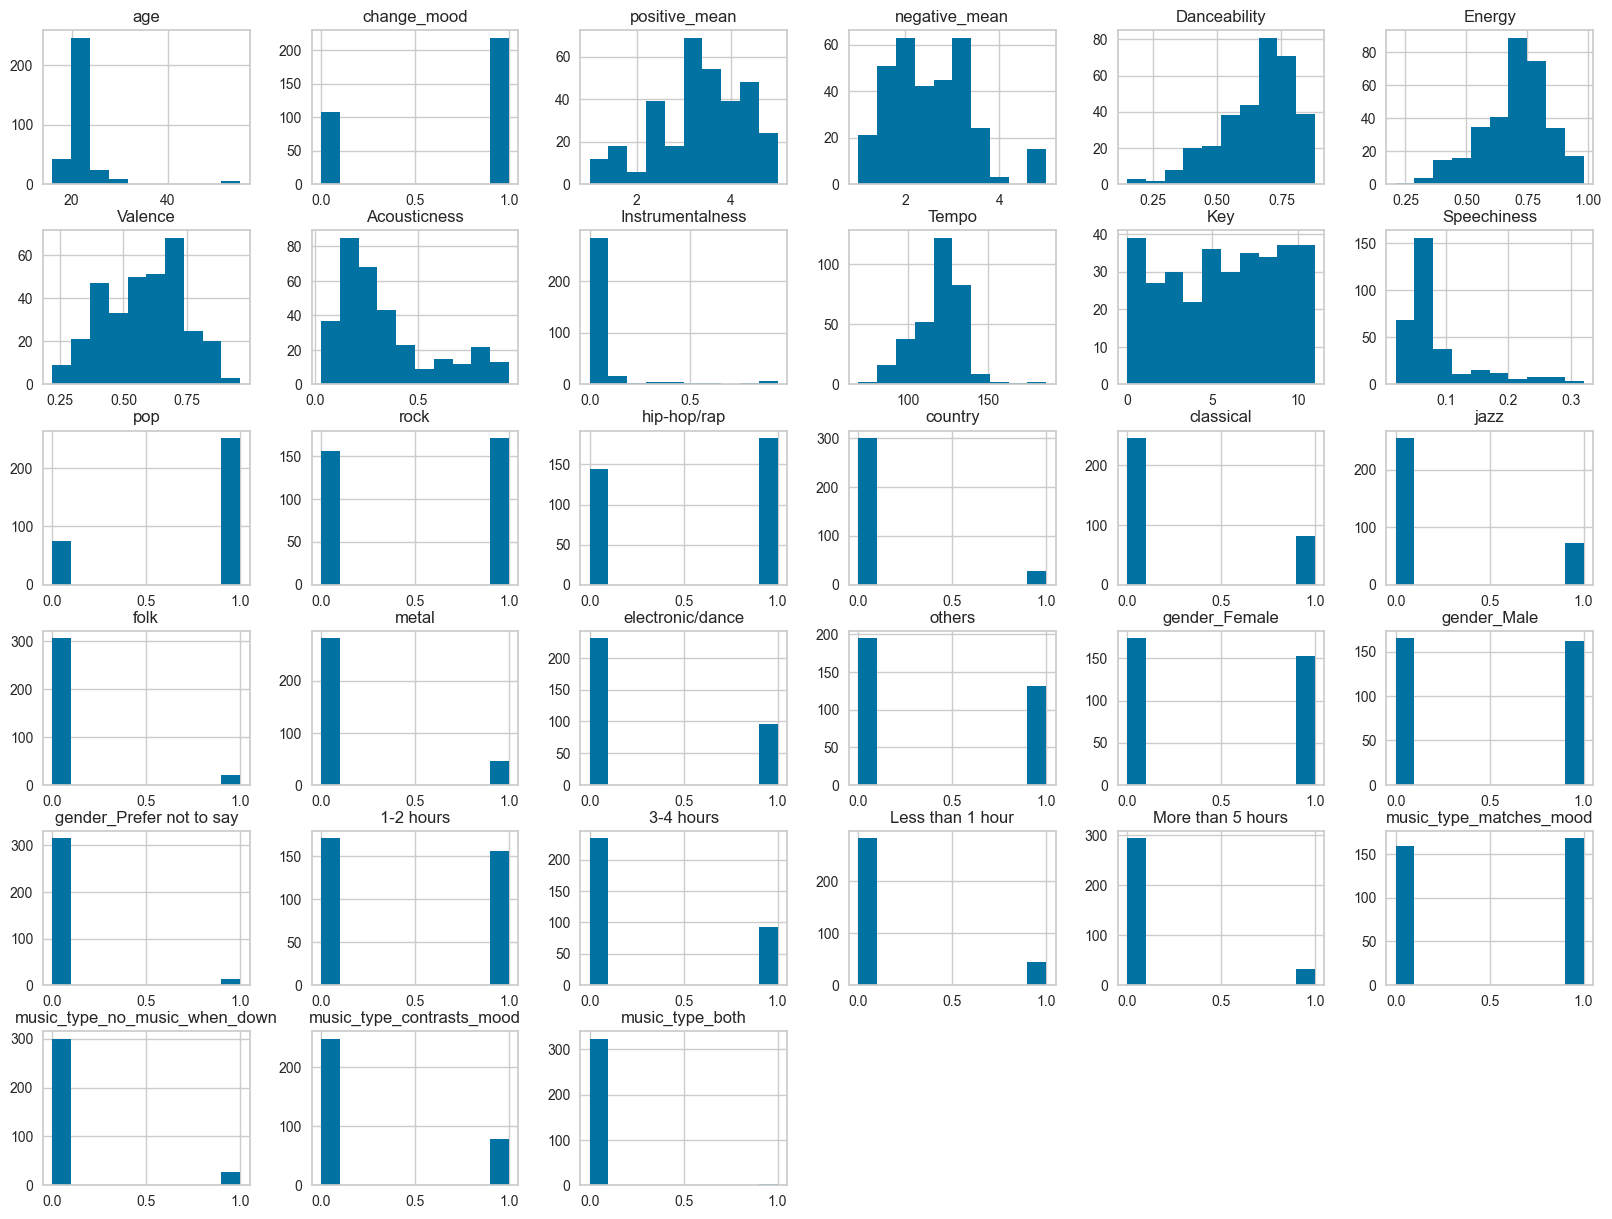

In [145]:
df.hist(figsize=(20, 15))
plt.show()

# Preprocess data

In [146]:
df.isna().sum()

age                              0
change_mood                      0
positive_mean                    0
negative_mean                    0
Song                             0
Danceability                     0
Energy                           0
Valence                          0
Acousticness                     0
Instrumentalness                 0
Tempo                            0
Key                              0
Speechiness                      0
pop                              0
rock                             0
hip-hop/rap                      0
country                          0
classical                        0
jazz                             0
folk                             0
metal                            0
electronic/dance                 0
others                           0
gender_Female                    0
gender_Male                      0
gender_Prefer not to say         0
1-2 hours                        0
3-4 hours                        0
Less than 1 hour    

In [147]:
df['mental_positive'] = np.where(df['positive_mean'] - df['negative_mean'] > 0, 1, 0)

df.drop(columns=['positive_mean', 'negative_mean'], inplace=True)

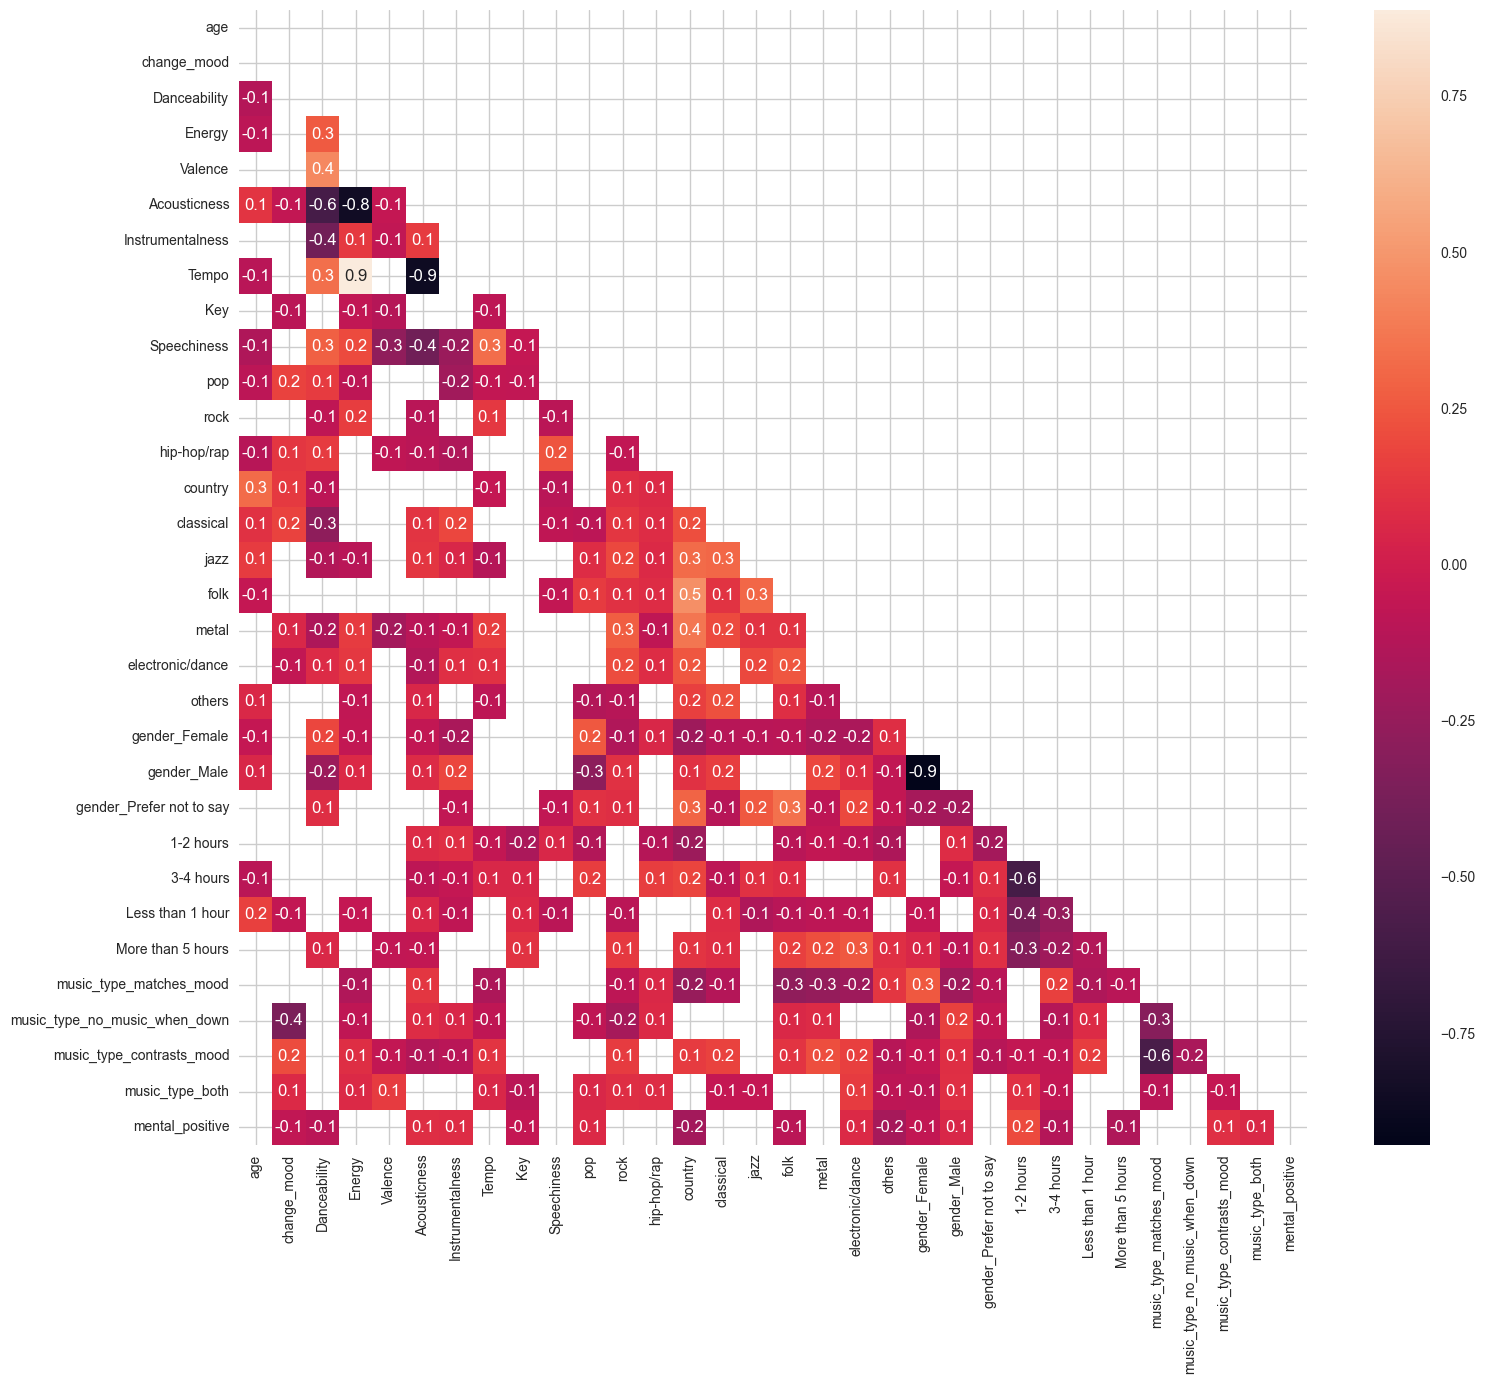

In [148]:
df_temp = df.drop(columns=['Song'])
plt.figure(figsize=(16, 14))  # Much larger figure size
sns.heatmap(df_temp.corr(),annot=True,fmt='.1f',mask = np.triu(np.ones_like(df_temp.corr(), dtype=bool))|(abs(df_temp.corr())<0.05))
plt.tight_layout()

In [149]:
target = np.array(df.mental_positive)
x = df.drop(columns=['mental_positive','Song'])

In [150]:
x.columns

Index(['age', 'change_mood', 'Danceability', 'Energy', 'Valence',
       'Acousticness', 'Instrumentalness', 'Tempo', 'Key', 'Speechiness',
       'pop', 'rock', 'hip-hop/rap', 'country', 'classical', 'jazz', 'folk',
       'metal', 'electronic/dance', 'others', 'gender_Female', 'gender_Male',
       'gender_Prefer not to say', '1-2 hours', '3-4 hours',
       'Less than 1 hour', 'More than 5 hours', 'music_type_matches_mood',
       'music_type_no_music_when_down', 'music_type_contrasts_mood',
       'music_type_both'],
      dtype='object')

# Decision Tree Classifier


In [151]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3,shuffle=True,stratify=target, random_state=42)

In [152]:
scaler=MinMaxScaler()
scaler.fit(X_train)
x_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
x_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

In [153]:
DT3=DecisionTreeClassifier()
cv = StratifiedKFold(5)
param_val = [{'criterion':['entropy','gini'],'max_depth':[0,10],'min_samples_split':np.arange(2,10,2)}]
#grid search configuration
grid = GridSearchCV(DT3, param_val, cv = cv,scoring='roc_auc_ovr')
#fitting into our data
grid.fit(X_train, y_train)

/Users/bhun/School/Big Data and AI/Final Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/bhun/School/Big Data and AI/Final Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/bhun/School/Big Data and AI/Final Project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/bhun/School/Big Data and AI/Final Project/.venv/

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['entropy', 'gini'],
                          'max_depth': [0, 10],
                          'min_samples_split': array([2, 4, 6, 8])}],
             scoring='roc_auc_ovr')

In [154]:
print(grid.best_score_)
print(grid.best_params_)

0.7078179989944695
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': np.int64(2)}


In [155]:
y_pred_2=grid.predict(X_test)
y_pred_2_prob=grid.predict_proba(X_test)
metrics.roc_auc_score(y_test,y_pred_2,multi_class='ovr')

np.float64(0.5703371970495258)

/Users/bhun/School/Big Data and AI/Final Project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


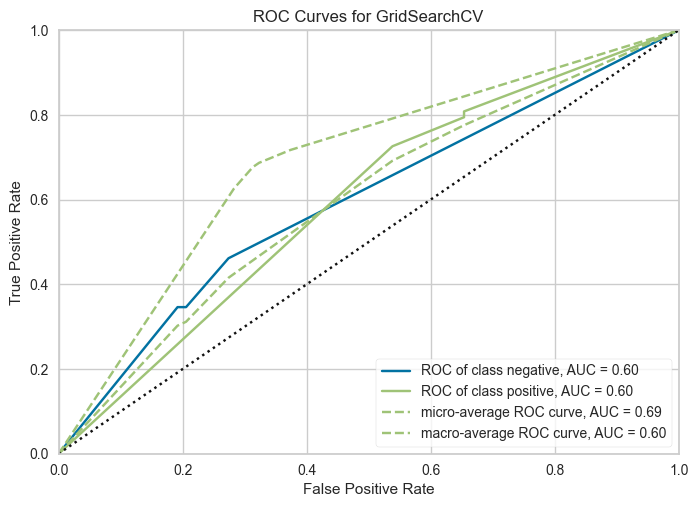

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [156]:
visualizer = ROCAUC(grid, classes=['negative', 'positive'])
visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test,y_test)        # Evaluate the model on the test data
visualizer.show()

In [157]:
dt_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_split=int(np.int64(8)),  # Ensure conversion to standard int
    random_state=100
)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=8, random_state=100)

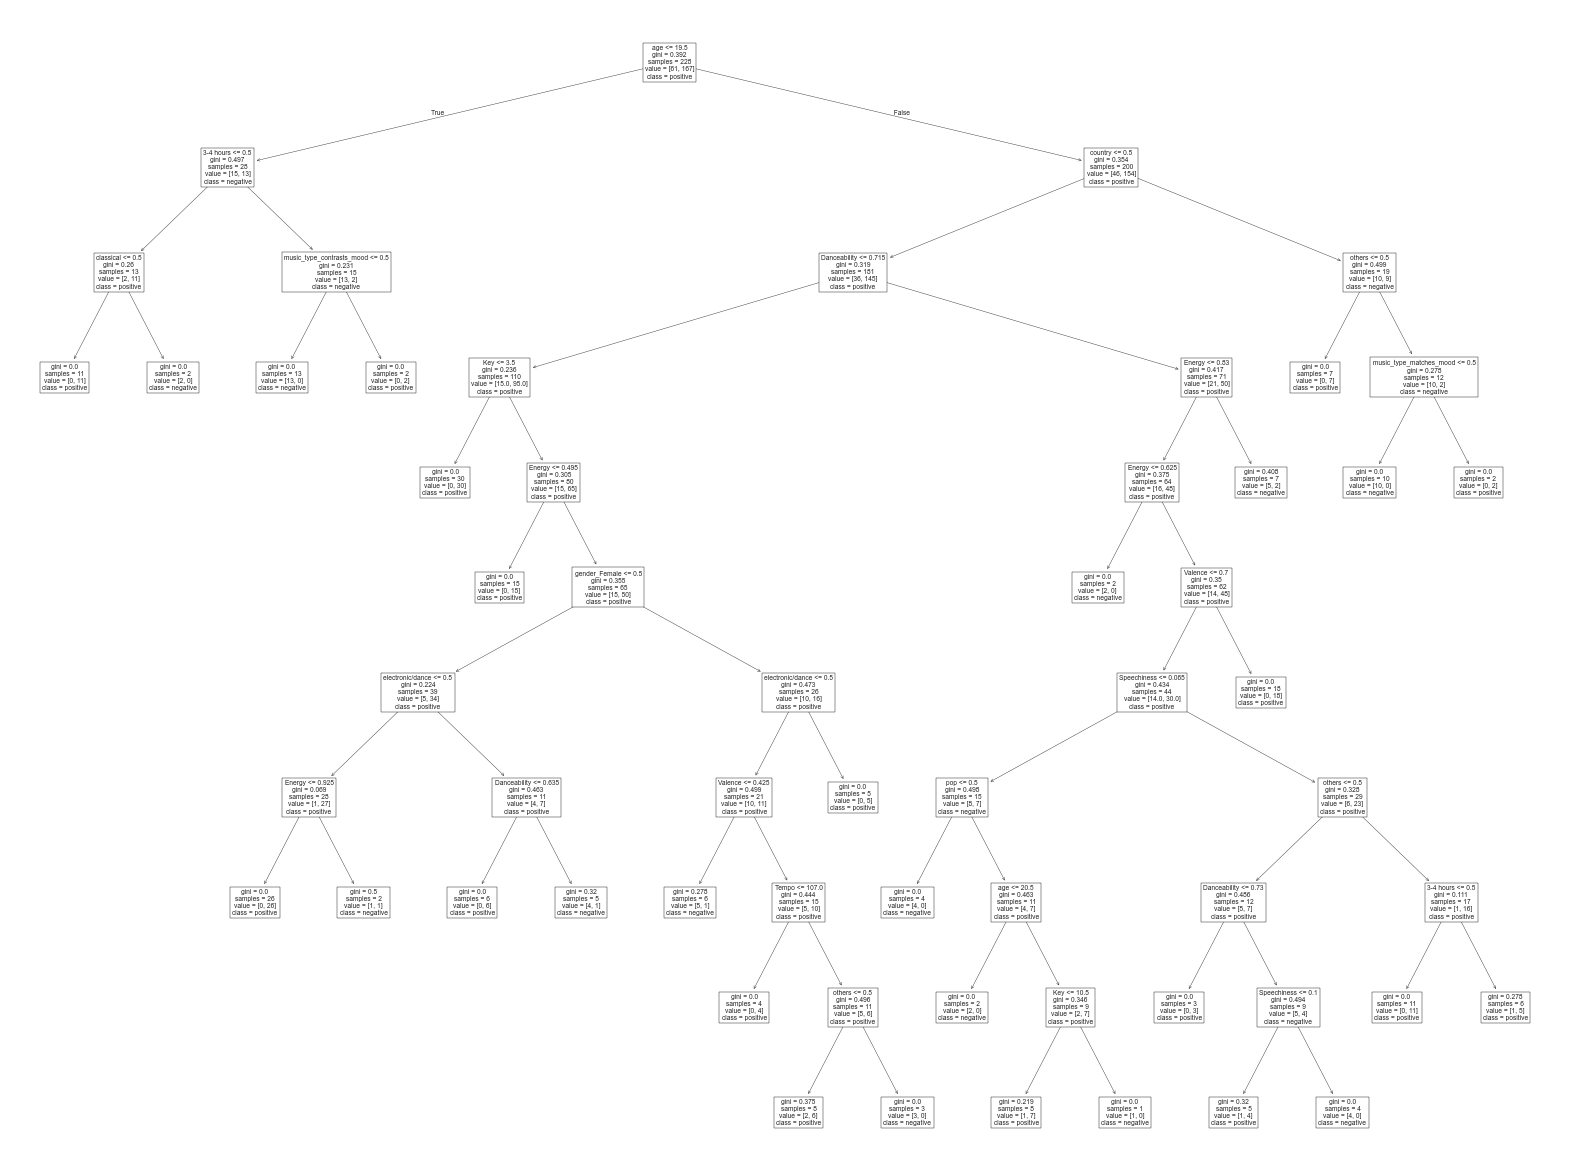

In [158]:
plt.figure(figsize=(20, 15))
plot_tree(dt_clf,feature_names=X_test.columns,class_names=['negative', 'positive'])
plt.show()


In [159]:
dt_clf.get_depth()

10

# Logistic

In [160]:
from sklearn.linear_model import LogisticRegression

### deal with imbalanced data

In [161]:
(df['mental_positive'] ==1).sum(), (df['mental_positive'] ==0).sum()

(np.int64(240), np.int64(87))

In [162]:
from sklearn.utils import resample

df_positive = df[df['mental_positive'] == 1] #majority class
df_negative = df[df['mental_positive'] == 0]

df_downsampled = resample(df_positive, 
                                 replace=False,    # sample without replacement
                                 n_samples=84,     # to match minority class
                                 random_state=42)

df_balanced = pd.concat([df_downsampled, df_negative])

In [163]:
(df_balanced['mental_positive'] ==1).sum(), (df_balanced['mental_positive'] ==0).sum()

(np.int64(84), np.int64(87))

In [164]:
target = np.array(df_balanced.mental_positive)
x = df_balanced.drop(columns=['mental_positive','Song'])

### preprocess

In [165]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3,shuffle=True,stratify=target)

In [166]:
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

In [167]:
X_train.iloc[:,:19].corr().round(2).mask((X_train.corr()<=0.7)&(X_train.corr()>=-0.7),'')

,age,change_mood,Danceability,Energy,Valence,Acousticness,Instrumentalness,Tempo,Key,Speechiness,pop,rock,hip-hop/rap,country,classical,jazz,folk,metal,electronic/dance
age,1.0,,,,,,,,,,,,,,,,,,
change_mood,,1.0,,,,,,,,,,,,,,,,,
Danceability,,,1.0,,,,,,,,,,,,,,,,
Energy,,,,1.0,,-0.83,,0.91,,,,,,,,,,,
Valence,,,,,1.0,,,,,,,,,,,,,,
Acousticness,,,,-0.83,,1.0,,-0.8,,,,,,,,,,,
Instrumentalness,,,,,,,1.0,,,,,,,,,,,,
Tempo,,,,0.91,,-0.8,,1.0,,,,,,,,,,,
Key,,,,,,,,,1.0,,,,,,,,,,
Speechiness,,,,,,,,,,1.0,,,,,,,,,


In [168]:
X_train.iloc[:,10:].corr().round(2).mask((X_train.corr()<=0.7)&(X_train.corr()>=-0.7),'')

,pop,rock,hip-hop/rap,country,classical,jazz,folk,metal,electronic/dance,others,...,gender_Male,gender_Prefer not to say,1-2 hours,3-4 hours,Less than 1 hour,More than 5 hours,music_type_matches_mood,music_type_no_music_when_down,music_type_contrasts_mood,music_type_both
pop,1.0,,,,,,,,,,...,,,,,,,,,,
rock,,1.0,,,,,,,,,...,,,,,,,,,,
hip-hop/rap,,,1.0,,,,,,,,...,,,,,,,,,,
country,,,,1.0,,,,,,,...,,,,,,,,,,
classical,,,,,1.0,,,,,,...,,,,,,,,,,
jazz,,,,,,1.0,,,,,...,,,,,,,,,,
folk,,,,,,,1.0,,,,...,,,,,,,,,,
metal,,,,,,,,1.0,,,...,,,,,,,,,,
electronic/dance,,,,,,,,,1.0,,...,,,,,,,,,,
others,,,,,,,,,,1.0,...,,,,,,,,,,


In [169]:
# Drop features with high correlation
X_train = X_train.drop(columns=['Tempo','Acousticness'])

### model

In [170]:
lrc=LogisticRegression( multi_class='ovr',solver='saga',random_state=100)

#Train the model using the training sets
lrc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_test = lrc.predict(X_test.drop(columns=['Tempo','Acousticness']))
y_pred_train = lrc.predict(X_train)

/Users/bhun/School/Big Data and AI/Final Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report: 
               precision    recall  f1-score   support

    negative       0.63      0.73      0.68        26
    positive       0.68      0.58      0.62        26

    accuracy                           0.65        52
   macro avg       0.66      0.65      0.65        52
weighted avg       0.66      0.65      0.65        52
 

Accuracy on train:   0.7394957983193278 

Accuracy on test:  0.6538461538461539 



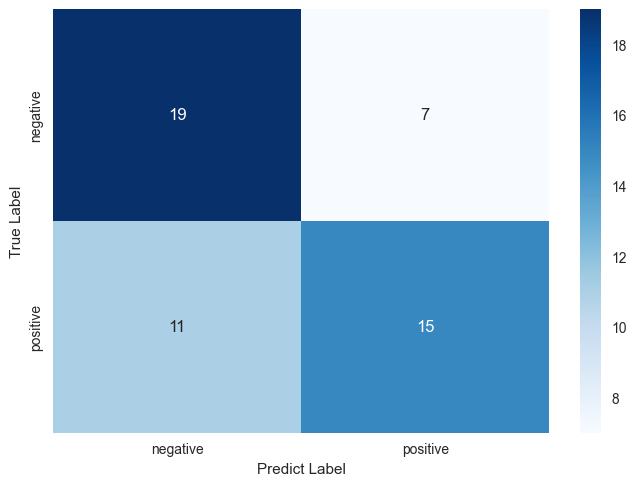

In [171]:
print("Classification Report: \n", metrics.classification_report(y_test,y_pred_test,target_names=['negative', 'positive']),'\n')
print("Accuracy on train:  ",lrc.score(X_train,y_train),'\n')
print("Accuracy on test: ",lrc.score(X_test.drop(columns=['Tempo','Acousticness']),y_test),'\n')
cf=metrics.confusion_matrix(y_test,y_pred_test)
sns.heatmap(cf, annot=True, fmt="d", cmap="Blues", xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

# KNN

In [172]:
from sklearn.neighbors import KNeighborsClassifier

In [173]:
X_train, X_test, y_train, y_test = train_test_split(x, target, test_size=0.3,shuffle=True,stratify=target)

In [174]:
scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)

In [175]:
#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_train)

Classification Report: 
               precision    recall  f1-score   support

    positive       0.73      0.92      0.81        61
    negative       0.88      0.64      0.74        58

    accuracy                           0.78       119
   macro avg       0.80      0.78      0.78       119
weighted avg       0.80      0.78      0.78       119
 

Accuracy:  0.7815126050420168 



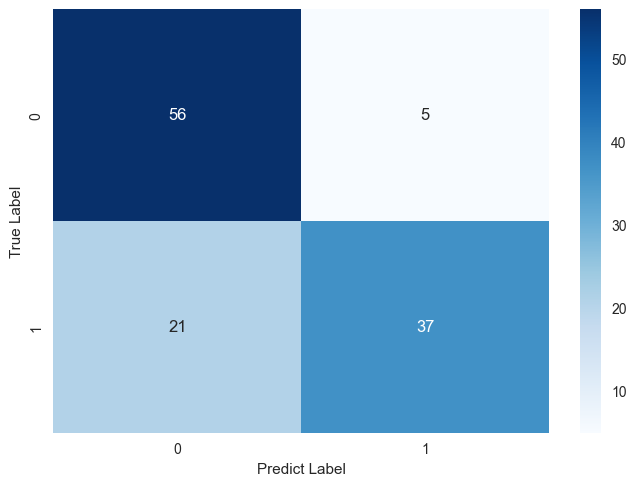

In [176]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Classification Report: \n", metrics.classification_report(y_train,y_pred,target_names=['positive','negative']),'\n')
print("Accuracy: ",metrics.accuracy_score(y_train,y_pred),'\n')
cf=metrics.confusion_matrix(y_train,y_pred).round(3)
sns.heatmap(cf,annot=True,cmap='Blues')
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

/Users/bhun/School/Big Data and AI/Final Project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


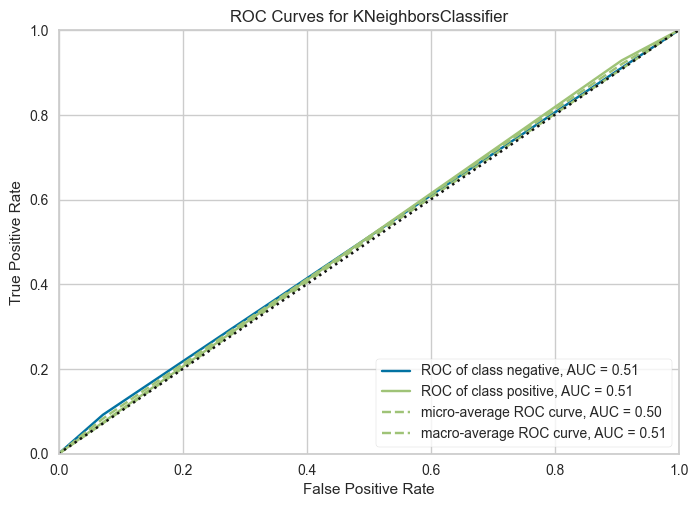

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [177]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(knn, classes=['negative','positive'])
visualizer.fit(x, target)        # Fit the training data to the visualizer
visualizer.score(x,target)        # Evaluate the model on the test data
visualizer.show()

## Neural Network

In [178]:
# First split into train and temp (temp will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(x, target, test_size=0.3, shuffle=True, stratify=target)

# Split temp into validation and test sets (50% of temp each, which is 15% of original data)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, stratify=y_temp)

scaler=MinMaxScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=x.columns)
X_val=pd.DataFrame(scaler.transform(X_val),columns=x.columns)
X_test=pd.DataFrame(scaler.transform(X_test),columns=x.columns)

In [179]:
y_train

array([1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1])

Training with: batch_size=16, hidden_size=32, lr=0.05, epochs=20
Validation Accuracy: 0.6154, AUC: 0.9112
Training with: batch_size=16, hidden_size=32, lr=0.05, epochs=30
Validation Accuracy: 0.5769, AUC: 0.6450
Training with: batch_size=16, hidden_size=32, lr=0.05, epochs=50
Validation Accuracy: 0.5769, AUC: 0.5888
Training with: batch_size=16, hidden_size=32, lr=0.001, epochs=20
Validation Accuracy: 0.5769, AUC: 0.7988
Training with: batch_size=16, hidden_size=32, lr=0.001, epochs=30
Validation Accuracy: 0.7308, AUC: 0.8047
Training with: batch_size=16, hidden_size=32, lr=0.001, epochs=50
Validation Accuracy: 0.8462, AUC: 0.8639
Training with: batch_size=16, hidden_size=32, lr=0.005, epochs=20
Validation Accuracy: 0.6154, AUC: 0.8639
Training with: batch_size=16, hidden_size=32, lr=0.005, epochs=30
Validation Accuracy: 0.8462, AUC: 0.9645
Training with: batch_size=16, hidden_size=32, lr=0.005, epochs=50
Validation Accuracy: 0.9231, AUC: 0.9704
Training with: batch_size=16, hidden_siz

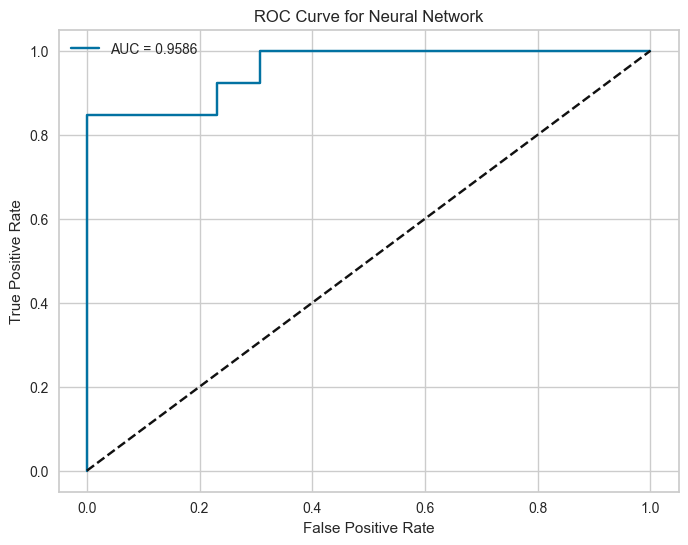

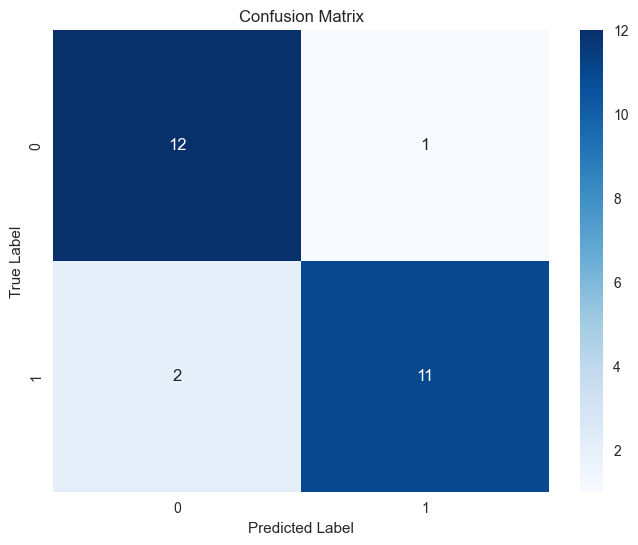

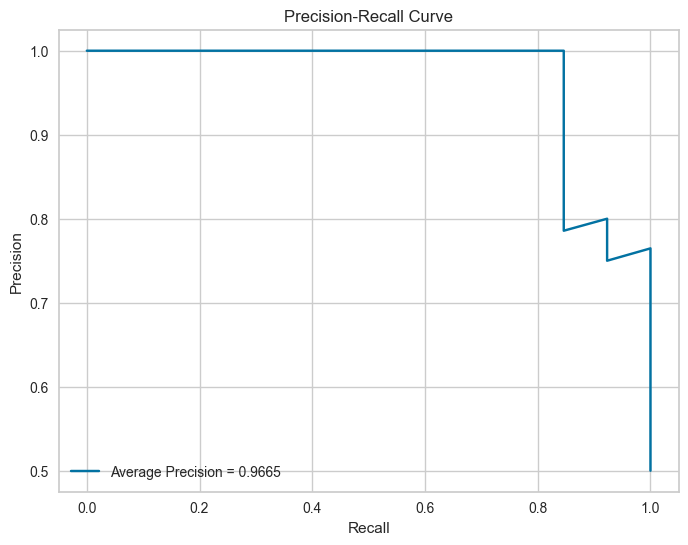

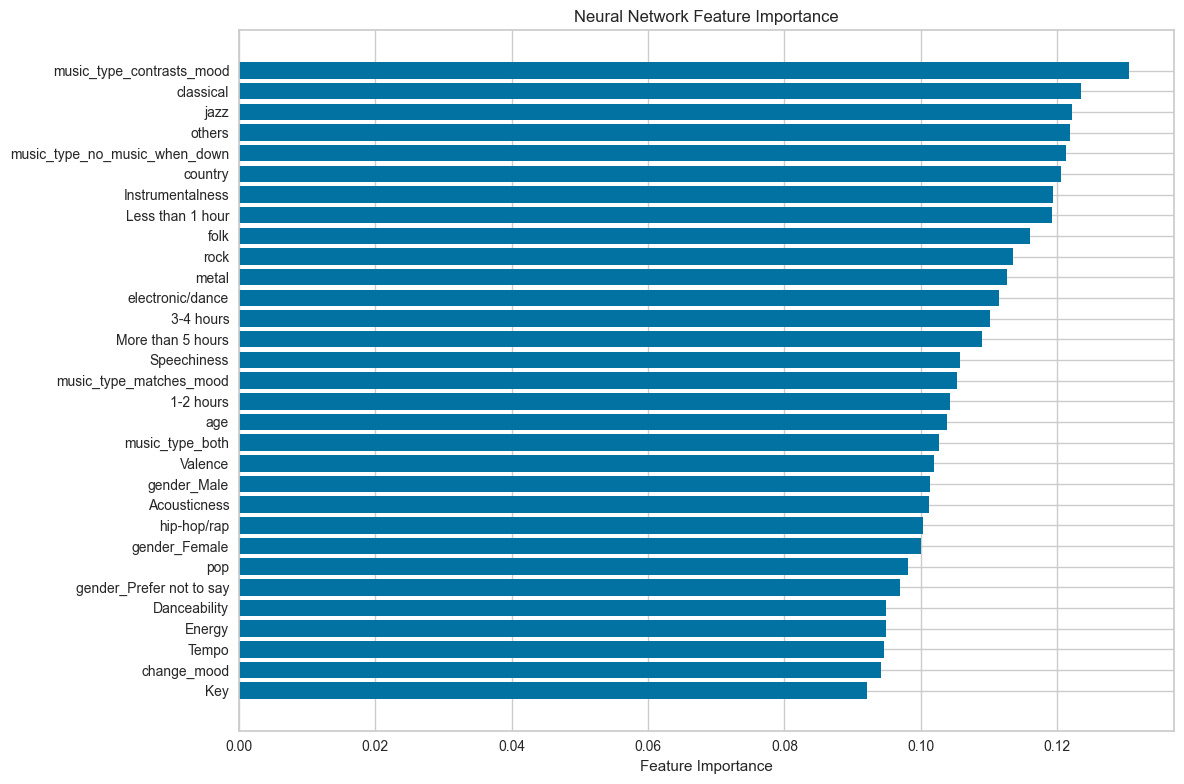

In [182]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.LongTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Neural network model
class MoodClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2):
        super(MoodClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_2, hidden_size_2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size_2, 2)
        )
    
    def forward(self, x):
        return self.model(x)

# Grid search parameters
param_grid = {
    'batch_size': [16, 32],
    'hidden_size': [32, 64, 128, 256],
    'learning_rate': [0.05, 0.001, 0.005],
    'epochs': [20, 30, 50]
}

# Function to train and evaluate model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=30):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    best_model_state = model.state_dict().copy()
    
    for epoch in range(epochs):
        # Training
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model

# Perform grid search
results = []
input_size = X_train.shape[1]

for batch_size in param_grid['batch_size']:
    for hidden_size in param_grid['hidden_size']:
        for lr in param_grid['learning_rate']:
            for num_epochs in param_grid['epochs']:
                print(f"Training with: batch_size={batch_size}, hidden_size={hidden_size}, lr={lr}, epochs={num_epochs}")
                
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size)
                
                model = MoodClassifier(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size//2)
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)
                
                model = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=num_epochs)
                
                # Evaluate on validation set
                model.eval()
                all_preds = []
                all_probs = []
                all_labels = []
                
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        probs = torch.softmax(outputs, dim=1)[:, 1]
                        
                        all_preds.extend(preds.numpy())
                        all_probs.extend(probs.numpy())
                        all_labels.extend(labels.numpy())
                
                val_accuracy = accuracy_score(all_labels, all_preds)
                val_auc = roc_auc_score(all_labels, all_probs)
                
                results.append({
                    'batch_size': batch_size,
                    'hidden_size': hidden_size,
                    'learning_rate': lr,
                    'epochs': num_epochs,
                    'val_accuracy': val_accuracy,
                    'val_auc': val_auc,
                    'model': model
                })
                
                print(f"Validation Accuracy: {val_accuracy:.4f}, AUC: {val_auc:.4f}")

# Find best model
best_result = max(results, key=lambda x: x['val_accuracy'])
best_model = best_result['model']
print(f"\nBest Model: batch_size={best_result['batch_size']}, hidden_size={best_result['hidden_size']}, learning_rate={best_result['learning_rate']}, epochs={best_result['epochs']}, val_auc={best_result['val_auc']:.4f}")

# Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=best_result['batch_size'])
best_model.eval()
test_preds = []
test_probs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        
        test_preds.extend(preds.numpy())
        test_probs.extend(probs.numpy())
        test_labels.extend(labels.numpy())

test_accuracy = accuracy_score(test_labels, test_preds)
test_auc = roc_auc_score(test_labels, test_probs)
print(f"Test Accuracy: {test_accuracy:.4f}, AUC: {test_auc:.4f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(test_labels, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Neural Network')
plt.legend()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
avg_precision = average_precision_score(test_labels, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Average Precision = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance using model weights (for the first layer)
feature_names = x.columns
weights = best_model.model[0].weight.data.numpy() if hasattr(best_model, 'model') else np.ones((1, len(feature_names)))
importance = np.abs(weights).mean(axis=0)
plt.figure(figsize=(12, 8))
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Neural Network Feature Importance')
plt.tight_layout()
plt.show()